# Prophet Python Baseline

In [71]:
# load packages
import pandas as pd
import numpy as np
from fbprophet import Prophet
import os

import warnings

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Necessary functions

In [89]:
# custom MAPE
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

# custom MAE
def mae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred)))

In [7]:
# create timeframe data for prediction
total_timeframe = pd.DataFrame(pd.date_range(start='2013-01-01', end='2016-12-31', freq="D")).rename({0:"ds"}, axis=1)
timeframe = pd.read_csv("../data/timeframe.csv", index_col=0)

In [8]:
def run_prophet(series, timeframe=timeframe):
    """
    Runs the Prophet 
    
    Key arguments:
    --------------
    series -- (DataFrame) time series data
    timeframe -- (DataFrame) a DataFrame with one column 
                 consisting of predicted dates

    Returns: 
    --------------
    Returns the forecast of the predictions 

    """
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
                    # changepoint_prior_scale=0.001,
                    # mcmc_samples=300,
                    interval_width=0.95)
    model.fit(series)
    forecast = model.predict(timeframe)
    return forecast, model

In [9]:
def aggregate_error(data, variable=None, method="mape"):
    """
    Given the combined data from our generated forecast and
    returns the aggregated error
    
    Key arguments:
    --------------
    data -- (dict) dictionary of data that we want to use
    variable -- (str) variable name
    method -- (str) mape or mae

    Returns: 
    --------------
    The aggregated MAPE or MAE of the forecast

    """
    test_pred = timeframe.copy()
    test_true = timeframe.copy()
    if variable is None:
        for i in data:
            test_pred = pd.merge(test_pred, data[i][["ds", "yhat"]], on="ds")
            test_true = pd.merge(test_true, data[i][["ds", "y"]], on="ds")
    else:
        for i in data:
            if variable in i:
                test_pred = pd.merge(test_pred, data[i][["ds", "yhat"]], on="ds")
                test_true = pd.merge(test_true, data[i][["ds", "y"]], on="ds")
    sum_pred = test_pred.sum(axis=1)
    sum_true = test_true.sum(axis=1)
    if method == "mape":
        return mape(sum_true, sum_pred)
    if method == "mae":
        return mae(sum_true, sum_pred)

In [90]:
# read data
raw_data = pd.read_csv("../data/train.csv", parse_dates=["SHIFT_DATE"])

In [91]:
# split data to train and val
train = raw_data[(raw_data["SHIFT_DATE"]>"2012-12-31") & (raw_data["SHIFT_DATE"]<"2017-01-01")]
val = raw_data[(raw_data["SHIFT_DATE"]>"2016-12-31") & (raw_data["SHIFT_DATE"]<"2018-01-01")]

# Split by Job Family and Site

In [92]:
# using only a portion of the sites
small_train = train[(train["SITE"]=="St Paul's Hospital") | 
                    (train["SITE"]=="Mt St Joseph") | 
                    (train["SITE"]=="Holy Family") | 
                    (train["SITE"]=="SVH Langara") | 
                    (train["SITE"]=="Brock Fahrni") | 
                    (train["SITE"]=="Youville Residence")]

small_val = val[(val["SITE"]=="St Paul's Hospital") | 
                (val["SITE"]=="Mt St Joseph") | 
                (val["SITE"]=="Holy Family") | 
                (val["SITE"]=="SVH Langara") | 
                (val["SITE"]=="Brock Fahrni") | 
                (val["SITE"]=="Youville Residence")]

In [97]:
# create training dataframes
splitting_train = small_train.groupby(["JOB_FAMILY", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_train = splitting_train.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

# create validation dataframes
splitting_val = small_val.groupby(["JOB_FAMILY", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_val = splitting_val.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [98]:
# create timeframe data for prediction
total_timeframe = pd.DataFrame(pd.date_range(start='2013-01-01', end='2016-12-31', freq="D")).rename({0:"ds"}, axis=1)
timeframe = pd.DataFrame(pd.date_range(start='2017-01-01', end='2017-12-31', freq="D")).rename({0:"ds"}, axis=1)

In [99]:
small_sites = small_train["SITE"].unique()
small_jfs = ["DC1000", "DC2A00", "DC2B00"]

In [220]:
warnings.simplefilter('ignore')
# create and store predictions and true results
models = {}
split_data = {}
pred_results = {}
true_results = {}
for i in small_sites:
    for j in small_jfs:
        temp_data_train = splitting_train[(splitting_train["SITE"]==i) & (splitting_train["JOB_FAMILY"]==j)].reset_index()
        temp_data_train = pd.merge(total_timeframe, temp_data_train, on="ds", how="outer")
        temp_data_train["y"] = temp_data_train["y"].fillna(0)
        
        temp_data_val = splitting_val[(splitting_val["SITE"]==i) & (splitting_val["JOB_FAMILY"]==j)].reset_index(drop=True)
        temp_data_val = pd.merge(timeframe, temp_data_val, on="ds", how="outer")
        temp_data_val["y"] = temp_data_val["y"].fillna(0)
        
        split_data[(i, j)] = temp_data_train
        true_results[(i, j)] = temp_data_val
        try:
            pred_results[(i, j)], models[(i,j)] = run_prophet(temp_data_train)
            print("Fitting -", i, j, ": Done")
        except ValueError:
            pred_results[(i, j)] = None
            print("Fitting -", i, j, ": Failed")

Fitting - St Paul's Hospital DC1000 : Done
Fitting - St Paul's Hospital DC2A00 : Done
Fitting - St Paul's Hospital DC2B00 : Done
Fitting - Mt St Joseph DC1000 : Done
Fitting - Mt St Joseph DC2A00 : Done
Fitting - Mt St Joseph DC2B00 : Done
Fitting - Youville Residence DC1000 : Done
Fitting - Youville Residence DC2A00 : Done
Fitting - Youville Residence DC2B00 : Done
Fitting - SVH Langara DC1000 : Done
Fitting - SVH Langara DC2A00 : Done
Fitting - SVH Langara DC2B00 : Done
Fitting - Brock Fahrni DC1000 : Done
Fitting - Brock Fahrni DC2A00 : Done
Fitting - Brock Fahrni DC2B00 : Done
Fitting - Holy Family DC1000 : Done
Fitting - Holy Family DC2A00 : Done
Fitting - Holy Family DC2B00 : Done


## Get weekly errors

In [221]:
# combine predictions and true results
combined = {}
for i in true_results:
    if pred_results[i] is not None:
        combined[i] = pd.merge(true_results[i], 
                               pred_results[i], 
                               on="ds", 
                               how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]

In [260]:
# convert to week and calculating errors weekly
weekly = {}
for i in combined:
    # create week column
    combined[i]["ds"] = combined[i]["ds"]-pd.DateOffset(weekday=0, weeks=1)
    combined[i]["week"] = combined[i]["ds"].dt.week

    # store y, yhat, yhat_lower, yhat_upper
    weekly_y = combined[i].groupby("ds").y.sum().reset_index()
    weekly_yhat = combined[i].groupby("ds").yhat.sum().round(0).astype(int).reset_index()
    weekly_yhat_lower = combined[i].groupby("ds").yhat_lower.sum().round(0).astype(int).reset_index()
    weekly_yhat_upper = combined[i].groupby("ds").yhat_upper.sum().round(0).astype(int).reset_index()

    # replace negative prediction values with 0
    weekly_yhat = weekly_yhat.where(weekly_yhat["yhat"] >= 0, 0)
    weekly_yhat_lower = weekly_yhat_lower.where(weekly_yhat_lower["yhat_lower"] >= 0, 0)
    weekly_yhat_upper = weekly_yhat_upper.where(weekly_yhat_upper["yhat_upper"] >= 0, 0)


    # merge weekly results
    weekly[i] = pd.concat([weekly_y, weekly_yhat["yhat"],
                           weekly_yhat_lower["yhat_lower"],
                           weekly_yhat_upper["yhat_upper"]],
                          axis=1)

    # create columns "year", "site", "JOB_FAMILY"
    length = weekly[i].shape[0]
    weekly[i]["week"] = weekly[i]["ds"].dt.weekofyear
    weekly[i]["site"] = np.repeat(i[0], length)
    weekly[i]["job_family"] = np.repeat(i[1], length)

In [261]:
for i in weekly:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly[i]["y"], weekly[i]["yhat"]), 
                                         mae(weekly[i]["y"], weekly[i]["yhat"])))

("St Paul's Hospital", 'DC1000'): MAPE: 5.164288029331788, MAE: 100.64150943396227
("St Paul's Hospital", 'DC2A00'): MAPE: 32.5758445361709, MAE: 38.43396226415094
("St Paul's Hospital", 'DC2B00'): MAPE: 24.20941722668481, MAE: 18.264150943396228
('Mt St Joseph', 'DC1000'): MAPE: 13.093594261071328, MAE: 38.24528301886792
('Mt St Joseph', 'DC2A00'): MAPE: 48.20761297529101, MAE: 8.49056603773585
('Mt St Joseph', 'DC2B00'): MAPE: inf, MAE: 5.773584905660377
('Youville Residence', 'DC1000'): MAPE: 18.280951424070523, MAE: 7.735849056603773
('Youville Residence', 'DC2A00'): MAPE: inf, MAE: 2.4716981132075473
('Youville Residence', 'DC2B00'): MAPE: inf, MAE: 1.2452830188679245
('SVH Langara', 'DC1000'): MAPE: 20.49649722444216, MAE: 9.566037735849056
('SVH Langara', 'DC2A00'): MAPE: inf, MAE: 4.90566037735849
('SVH Langara', 'DC2B00'): MAPE: inf, MAE: 1.1886792452830188
('Brock Fahrni', 'DC1000'): MAPE: 23.184243084027305, MAE: 6.113207547169812
('Brock Fahrni', 'DC2A00'): MAPE: inf, MAE: 

In [262]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

St Paul's Hospital: MAPE: 4.470086759678763, MAE: 103.56
Mt St Joseph: MAPE: 11.985502290490173, MAE: 44.48
Youville Residence: MAPE: 17.41472056248001, MAE: 8.16
SVH Langara: MAPE: 22.394178175745765, MAE: 11.2
Brock Fahrni: MAPE: 20.57268512381485, MAE: 8.92
Holy Family: MAPE: 21.698405953164762, MAE: 15.96


In [263]:
# errors for each labor agreement
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

DC1000: MAPE: 4.6271977361152, MAE: 122.22
DC2A00: MAPE: 30.3343073040784, MAE: 47.9
DC2B00: MAPE: 15.357802940796644, MAE: 19.0


In [264]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly, method="mape"), 
                                             aggregate_error(weekly, method="mae")))

Total MAPE: 4.59396041836476
Total MAE: 132.6


# Minimize error


In [265]:
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)


In [266]:
for i in weekly:
    forecasted = models[i].predict(total_timeframe)
    actual = split_data[i]

    error = actual["y"] - forecasted["yhat"]
    obs = total_timeframe.copy()
    obs["error"] = error
    obs = obs.set_index("ds")

    decomp = decompose(obs, period=365)
    weekly_fcast = forecast(decomp, steps=365, fc_func=drift, seasonal=True)
    weekly_fcast["week"] = weekly_fcast.index-pd.DateOffset(weekday=0, weeks=1)
    weekly_fcast = weekly_fcast.groupby("week").sum()

    resid_fcast = weekly_fcast.reset_index()["drift+seasonal"]
    weekly_yhat = (weekly[i]["yhat"] + resid_fcast).round(0)
    weekly_yhat_lower = (weekly[i]["yhat_lower"] + resid_fcast).round(0)
    weekly_yhat_upper = (weekly[i]["yhat_upper"] + resid_fcast).round(0)

    weekly[i]["yhat"] = weekly_yhat.where(weekly_yhat >= 0, 0)
    weekly[i]["yhat_lower"] = weekly_yhat_lower.where(weekly_yhat_lower >= 0, 0)
    weekly[i]["yhat_upper"] = weekly_yhat_upper.where(weekly_yhat_upper >= 0, 0)

# Print new errors

In [267]:
for i in weekly:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly[i]["y"], weekly[i]["yhat"]), 
                                         mae(weekly[i]["y"], weekly[i]["yhat"])))

("St Paul's Hospital", 'DC1000'): MAPE: 4.206521926903699, MAE: 78.66037735849056
("St Paul's Hospital", 'DC2A00'): MAPE: 32.5758445361709, MAE: 38.43396226415094
("St Paul's Hospital", 'DC2B00'): MAPE: 24.20941722668481, MAE: 18.264150943396228
('Mt St Joseph', 'DC1000'): MAPE: 14.51027917462437, MAE: 39.886792452830186
('Mt St Joseph', 'DC2A00'): MAPE: 48.20761297529101, MAE: 8.49056603773585
('Mt St Joseph', 'DC2B00'): MAPE: inf, MAE: 5.773584905660377
('Youville Residence', 'DC1000'): MAPE: 23.28158246912612, MAE: 10.09433962264151
('Youville Residence', 'DC2A00'): MAPE: inf, MAE: 2.4716981132075473
('Youville Residence', 'DC2B00'): MAPE: inf, MAE: 1.2452830188679245
('SVH Langara', 'DC1000'): MAPE: 20.661273582965272, MAE: 10.226415094339623
('SVH Langara', 'DC2A00'): MAPE: inf, MAE: 4.90566037735849
('SVH Langara', 'DC2B00'): MAPE: inf, MAE: 1.1886792452830188
('Brock Fahrni', 'DC1000'): MAPE: 24.41204540574981, MAE: 6.7924528301886795
('Brock Fahrni', 'DC2A00'): MAPE: inf, MAE: 

In [268]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

St Paul's Hospital: MAPE: 3.660168155142439, MAE: 83.96
Mt St Joseph: MAPE: 12.339193098264769, MAE: 46.18
Youville Residence: MAPE: 19.109235905317917, MAE: 9.44
SVH Langara: MAPE: 19.511938083866674, MAE: 10.36
Brock Fahrni: MAPE: 20.99888064028913, MAE: 9.08
Holy Family: MAPE: 22.275562990152334, MAE: 17.28


In [269]:
# errors for each labor agreement
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

DC1000: MAPE: 3.882437656318359, MAE: 101.48
DC2A00: MAPE: 30.3343073040784, MAE: 47.9
DC2B00: MAPE: 15.357802940796644, MAE: 19.0


In [270]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly, method="mape"), 
                                             aggregate_error(weekly, method="mae")))

Total MAPE: 3.84955198923054
Total MAE: 110.34


### Run below code to export tables

In [25]:
# create data/predictions folder if it doesn't exist
predictions_path = "../data/predictions/"
if not os.path.exists(predictions_path):
    os.mkdir(predictions_path)


# export to "data/predictions/" directory
total_data = pd.DataFrame()
for i in weekly:
    total_data = pd.concat([total_data, weekly[i]], axis=0)
total_data.to_csv(predictions_path + "predictions.csv")

# Split by Job Family, Site, and Sub Program

In [50]:
# create training dataframes
splitting_train2 = small_train.groupby(["JOB_FAMILY_DESCRIPTION", "SITE", "SUB_PROGRAM", "SHIFT_DATE"]).size().reset_index()
splitting_train2 = splitting_train2.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

# create validation dataframes
splitting_val2 = small_val.groupby(["JOB_FAMILY_DESCRIPTION", "SITE", "SUB_PROGRAM", "SHIFT_DATE"]).size().reset_index()
splitting_val2 = splitting_val2.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [51]:
small_subprograms = small_train["SUB_PROGRAM"].unique()

In [52]:
warnings.simplefilter('ignore')
# create and store predictions and true results
models2 = {}
split_data2 = {}
pred_results2 = {}
true_results2 = {}
for i in small_sites:
    for j in small_jfs:
        for k in small_subprograms:
            temp_data_train = splitting_train2[(splitting_train2["SITE"]==i) & (splitting_train2["JOB_FAMILY_DESCRIPTION"]==j) & (splitting_train2["SUB_PROGRAM"]==k)].reset_index()
            temp_data_train = pd.merge(total_timeframe, temp_data_train, on="ds", how="outer")
            temp_data_train["y"] = temp_data_train["y"].fillna(0)

            temp_data_val = splitting_val2[(splitting_val2["SITE"]==i) & (splitting_val2["JOB_FAMILY_DESCRIPTION"]==j) & (splitting_val2["SUB_PROGRAM"]==k)].reset_index(drop=True)
            temp_data_val = pd.merge(timeframe, temp_data_val, on="ds", how="outer")
            temp_data_val["y"] = temp_data_val["y"].fillna(0)

            split_data2[(i, j, k)] = temp_data_train
            true_results2[(i, j, k)] = temp_data_val
            try:
                pred_results2[(i, j, k)], models2[(i, j, k)] = run_prophet(temp_data_train)
                print("Fitting -", i, j, k, ": Done")
            except ValueError:
                pred_results2[(i, j, k)] = None
                print("Fitting -", i, j, k, ": Failed")

Fitting - St Paul's Hospital Registered Nurse-DC1 HEMODIALYSIS 6CD IC : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 LAUNDRY : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 PARKVIEW, 1 SOUTH : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 CLINICS : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 10C, CLINICS : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 RENAL CDU IAMHD : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 RES SVCS MSJ : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 ACCESS SVCS SPH : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 SPH INPATIENT : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 OR PAR SPH : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 PALLIATIVE SRVCS : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 RES SVCS LAN : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 BARBARA HALL : Done
Fitting - St Paul's Hospital Registered Nurse-DC1 EMERG SPH : Done
Fitting - St

In [53]:
# number of predictions
len(pred_results2)

1962

## Weekly errors

In [54]:
# combine predictions and true results
combined2 = {}
for i in true_results2:
    if pred_results2[i] is not None:
        combined2[i] = pd.merge(true_results2[i], 
                               pred_results2[i], 
                               on="ds", 
                               how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]

In [55]:
# convert to week and calculating errors weekly
weekly2 = {}
for i in combined2:
    # create week column
    combined2[i]["ds"] = combined2[i]["ds"]-pd.DateOffset(weekday=0, weeks=1)
    combined2[i]["week"] = combined2[i]["ds"].dt.week

    # store y, yhat, yhat_lower, yhat_upper
    weekly_y = combined2[i].groupby("ds").y.sum().reset_index()
    weekly_yhat = combined2[i].groupby("ds").yhat.sum().round(0).astype(int).reset_index()
    weekly_yhat_lower = combined2[i].groupby("ds").yhat_lower.sum().round(0).astype(int).reset_index()
    weekly_yhat_upper = combined2[i].groupby("ds").yhat_upper.sum().round(0).astype(int).reset_index()

    # replace negative prediction values with 0
    weekly_yhat = weekly_yhat.where(weekly_yhat["yhat"] >= 0, 0)
    weekly_yhat_lower = weekly_yhat_lower.where(weekly_yhat_lower["yhat_lower"] >= 0, 0)
    weekly_yhat_upper = weekly_yhat_upper.where(weekly_yhat_upper["yhat_upper"] >= 0, 0)


    # merge weekly results
    weekly2[i] = pd.concat([weekly_y, weekly_yhat["yhat"],
                           weekly_yhat_lower["yhat_lower"],
                           weekly_yhat_upper["yhat_upper"]],
                          axis=1)

    # create columns "year", "site", "job_family", "sub_program"
    length = weekly2[i].shape[0]
    weekly2[i]["week"] = weekly2[i]["ds"].dt.weekofyear
    weekly2[i]["site"] = np.repeat(i[0], length)
    weekly2[i]["job_family"] = np.repeat(i[1], length)
    weekly2[i]["sub_program"] = np.repeat(i[2], length)

In [56]:
for i in weekly2:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly2[i]["y"], weekly2[i]["yhat"]), 
                                         mae(weekly2[i]["y"], weekly2[i]["yhat"])))

("St Paul's Hospital", 'Registered Nurse-DC1', 'HEMODIALYSIS 6CD IC'): MAPE: 6.951702082080678, MAE: 9.0
("St Paul's Hospital", 'Registered Nurse-DC1', 'LAUNDRY'): MAPE: nan, MAE: 0.0
("St Paul's Hospital", 'Registered Nurse-DC1', 'PARKVIEW, 1 SOUTH'): MAPE: nan, MAE: 0.0
("St Paul's Hospital", 'Registered Nurse-DC1', 'CLINICS'): MAPE: 21.700565349345826, MAE: 9.037735849056604
("St Paul's Hospital", 'Registered Nurse-DC1', '10C, CLINICS'): MAPE: 20.09361119885547, MAE: 17.81132075471698
("St Paul's Hospital", 'Registered Nurse-DC1', 'RENAL CDU IAMHD'): MAPE: 21.191312982303252, MAE: 14.50943396226415
("St Paul's Hospital", 'Registered Nurse-DC1', 'RES SVCS MSJ'): MAPE: nan, MAE: 0.0
("St Paul's Hospital", 'Registered Nurse-DC1', 'ACCESS SVCS SPH'): MAPE: 100.0, MAE: 0.11320754716981132
("St Paul's Hospital", 'Registered Nurse-DC1', 'SPH INPATIENT'): MAPE: 11.964042412530745, MAE: 10.566037735849056
("St Paul's Hospital", 'Registered Nurse-DC1', 'OR PAR SPH'): MAPE: 8.187245056500844, 

In [57]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

St Paul's Hospital: MAPE: 4.264923762421946, MAE: 98.32692307692308
Mt St Joseph: MAPE: 12.942743756173018, MAE: 47.94230769230769
Youville Residence: MAPE: 18.202562753416125, MAE: 8.557692307692308
SVH Langara: MAPE: 23.032930223520786, MAE: 11.403846153846153
Brock Fahrni: MAPE: 19.959418983251435, MAE: 8.461538461538462
Holy Family: MAPE: 21.854958811297514, MAE: 15.884615384615385


In [58]:
# errors for each labor agreement
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

Registered Nurse-DC1: MAPE: 4.490798960483808, MAE: 118.21153846153847
Registered Nurse-DC2A Sup: MAPE: 30.120710795600157, MAE: 47.61538461538461
Registered Nurse-DC2B: MAPE: 15.139028835840392, MAE: 16.673076923076923


In [59]:
# errors for each labor agreement
for i in small_subprograms:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

HEMODIALYSIS 6CD IC: MAPE: 7.641408548041484, MAE: 10.51923076923077
LAUNDRY: MAPE: nan, MAE: 0.0
PARKVIEW, 1 SOUTH: MAPE: 16.16097760218875, MAE: 10.403846153846153
CLINICS: MAPE: 22.18115924255157, MAE: 10.307692307692308
10C, CLINICS: MAPE: 21.223486648159085, MAE: 22.0
RENAL CDU IAMHD: MAPE: 14.981726478753005, MAE: 11.653846153846153
RES SVCS MSJ: MAPE: 23.832362703944614, MAE: 7.423076923076923
ACCESS SVCS SPH: MAPE: 45.68032410651189, MAE: 3.7884615384615383
SPH INPATIENT: MAPE: 12.312148111642534, MAE: 12.365384615384615
OR PAR SPH: MAPE: 7.795034725025804, MAE: 25.576923076923077
PALLIATIVE SRVCS: MAPE: 31.648495460202298, MAE: 7.019230769230769
RES SVCS LAN: MAPE: 32.59009397408199, MAE: 12.538461538461538
BARBARA HALL: MAPE: 10.640701694626062, MAE: 14.692307692307692
EMERG SPH: MAPE: 11.538606072857473, MAE: 21.28846153846154
PLANT AND MAINTENANCE: MAPE: nan, MAE: 0.0
MSJ NURSING UNITS: MAPE: 15.873778442595377, MAE: 13.98076923076923
STAFF SCHED SVC: MAPE: 100.0, MAE: 0.05

In [60]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly2, method="mape"), 
                                             aggregate_error(weekly2, method="mae")))

Total MAPE: 4.486646059413157
Total MAE: 128.65384615384616


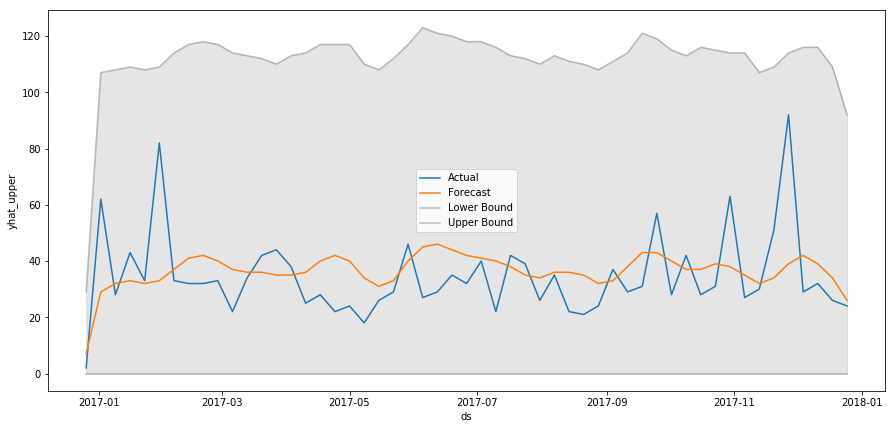

In [61]:
# native python plots
plot_data = weekly2[("Holy Family", 'Registered Nurse-DC1', 'RES SVCS HFH')]
ax = plt.subplots(figsize=(15,7))
ax = sns.lineplot(data=plot_data, x="ds", y="y", label="Actual")
ax = sns.lineplot(data=plot_data, x="ds", y="yhat", label="Forecast")
ax = sns.lineplot(data=plot_data, x="ds", y="yhat_lower", color="grey", alpha=0.5, label="Lower Bound")
ax = sns.lineplot(data=plot_data, x="ds", y="yhat_upper", color="grey", alpha=0.5, label="Upper Bound")
ax.fill_between(data=plot_data, x="ds", y1='yhat_lower', y2='yhat_upper', color="grey", alpha=0.2)

In [62]:
# # plot components
# var = ("St Paul's Hospital", 'Registered Nurse-DC1')
# models[var].plot_components(pred_results[var]);

### Run below code to export tables

In [63]:
# create data/predictions folder if it doesn't exist
predictions_path = "../data/predictions/"
if not os.path.exists(predictions_path):
    os.mkdir(predictions_path)


# export to "data/predictions/" directory
total_data = pd.DataFrame()
for i in weekly2:
    total_data = pd.concat([total_data, weekly2[i]], axis=0)
total_data.to_csv(predictions_path + "predictions_subprogram.csv")

# Save to pickle

In [65]:
import pickle

pickle_out = open("../data/predictions/predictions_subprogram.pickle","wb")
pickle.dump(weekly2, pickle_out)
pickle_out.close()

# Load pickle

In [69]:
pickle_in = open("../data/predictions/predictions_subprogram.pickle","rb")
example_dict = pickle.load(pickle_in)